<a href="https://colab.research.google.com/github/nader-hachana/skin_cancer_binary_classification/blob/master/binary_classification/v2_skin_cancer_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import os
import shutil

In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# data set link "https://www.kaggle.com/datasets/prashantjeswani/siim-isic-2019?select=ISIC_2019_Training_Metadata.csv"
!kaggle datasets download -d prashantjeswani/siim-isic-2019
!unzip siim-isic-2019.zip

In [4]:
os.rename('train','images')
os.rename('ISIC_2019_Training_GroundTruth.csv','labels.csv')
os.rename('ISIC_2019_Training_Metadata.csv','additional_info.csv')

In [5]:
seed = 1 # to get the same amount of split if we run the script multiple times
random.seed(seed)
directory = "ISIC/"
train = "data/train/"
test = "data/test/"
valid = "data/valid/"

os.makedirs(directory)
os.makedirs(train + "benign/")
os.makedirs(train + "malignant/")
os.makedirs(test + "benign/")
os.makedirs(test + "malignant/")
os.makedirs(valid + "benign/")
os.makedirs(valid + "malignant/")

shutil.move ( "/content/images", directory)
shutil.move ( "/content/labels.csv", directory)
shutil.move ( "/content/additional_info.csv", directory)

test_examples = train_examples = valid_examples = 0
# splitting data to 80% train, 10% validation, 10% test
for line in open("ISIC/labels.csv").readlines()[1:]:
  split_line = line.split(",")
  img_file = split_line[0]
  benign_malign = split_line[1]

  random_num = random.random()

  if random_num < 0.8:
    location = train
    train_examples += 1 

  elif random_num < 0.9:
    location = valid
    valid_examples += 1
    
  else:
    location = test
    test_examples += 1

  if int(float(benign_malign)) == 0:
    shutil.move(
        "ISIC/images/" + img_file + ".jpg",
        location + "benign/" + img_file + ".jpg",
    )
  elif int(float(benign_malign)) == 1:
    shutil.move(
        "ISIC/images/" + img_file + ".jpg",
        location + "malignant/" + img_file + ".jpg",
    )

print(f"Number of training examples {train_examples}")
print(f"Number of validation examples {valid_examples}")
print(f"Number of testing examples {test_examples}")

Number of training examples 20225
Number of validation examples 2551
Number of testing examples 2555


In [6]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [7]:
classes = ["benign","malignant"]

In [8]:
train_gen = ImageDataGenerator().flow_from_directory(directory="data/train/",classes=classes,target_size=(224,224),batch_size=32)
valid_gen = ImageDataGenerator().flow_from_directory(directory="data/valid/",classes=classes,target_size=(224,224),batch_size=32)
test_gen = ImageDataGenerator().flow_from_directory(directory="data/test/",classes=classes,target_size=(224,224),batch_size=32)

Found 20225 images belonging to 2 classes.
Found 2551 images belonging to 2 classes.
Found 2555 images belonging to 2 classes.


In [9]:
test_gen.class_indices

{'benign': 0, 'malignant': 1}

(32, 224, 224, 3)
[1. 0.]


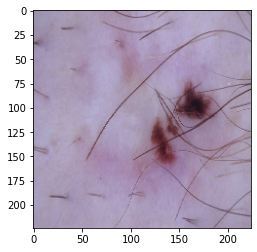

In [10]:
images , lables = next(test_gen)
print(images.shape)
plt.imshow(images[0]/255)
print(lables[0])

In [11]:
model = Sequential([

                    Conv2D(filters=32,kernel_size=(3,3),padding="same",input_shape=(224,224,3)),
                    MaxPool2D(pool_size=(2,2),strides=2),
                    Conv2D(filters=64,kernel_size=(3,3),padding="same"),
                    MaxPool2D(pool_size=(2,2),strides=2),
                    Flatten(),
                    Dense(64,activation="relu"),
                    Dense(64,activation="relu"),
                    Dense(128,activation="relu"),
                    Dense(2,activation="softmax")
])

# cNN

In [15]:
METRICS = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    #keras.metrics.Precision(name="precision"),
    #keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
]

In [16]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=METRICS)

In [17]:
history = model.fit(train_gen,validation_data=valid_gen,epochs=10)

Epoch 1/10
633/633 [==============================] - 461s 726ms/step - loss: 0.7347 - accuracy: 0.8197 - auc: 0.8176 - val_loss: 0.4611 - val_accuracy: 0.8267 - val_auc: 0.8267
Epoch 2/10
633/633 [==============================] - 456s 720ms/step - loss: 0.4707 - accuracy: 0.8206 - auc: 0.8203 - val_loss: 0.4640 - val_accuracy: 0.8267 - val_auc: 0.8267
Epoch 3/10
633/633 [==============================] - 464s 733ms/step - loss: 0.4709 - accuracy: 0.8206 - auc: 0.8206 - val_loss: 0.4615 - val_accuracy: 0.8267 - val_auc: 0.8267
Epoch 4/10
633/633 [==============================] - 470s 743ms/step - loss: 0.4707 - accuracy: 0.8206 - auc: 0.8224 - val_loss: 0.4610 - val_accuracy: 0.8267 - val_auc: 0.8267
Epoch 5/10
633/633 [==============================] - 451s 712ms/step - loss: 0.4709 - accuracy: 0.8206 - auc: 0.8175 - val_loss: 0.4615 - val_accuracy: 0.8267 - val_auc: 0.8267
Epoch 6/10
633/633 [==============================] - 455s 719ms/step - loss: 0.4709 - accuracy: 0.8206 - auc:

In [18]:
model.evaluate(valid_gen, verbose=2)
model.evaluate(test_gen, verbose=2)

80/80 - 41s - loss: 0.4618 - accuracy: 0.8267 - auc: 0.8267 - 41s/epoch - 514ms/step
80/80 - 49s - loss: 0.4666 - accuracy: 0.8235 - auc: 0.8235 - 49s/epoch - 616ms/step


[0.4665635824203491, 0.8234833478927612, 0.8234833478927612]

[0.7346705794334412, 0.47070789337158203, 0.47092369198799133, 0.47067001461982727, 0.4709424674510956, 0.47089463472366333, 0.47078341245651245, 0.4708505868911743, 0.47096824645996094, 0.4710308313369751]
[0.4611387252807617, 0.4639984965324402, 0.46153441071510315, 0.46102622151374817, 0.4615153670310974, 0.46108439564704895, 0.46120160818099976, 0.46122777462005615, 0.46285367012023926, 0.46182185411453247]


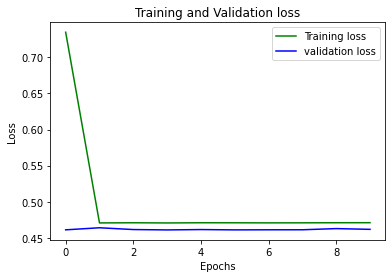

In [29]:
# Training and validation loss:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
loss_train = np.array(loss_train)
loss_val = np.array(loss_val)
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

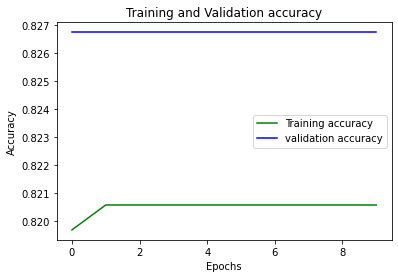

In [32]:
# Training and validation accuracy:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
plt.plot( loss_train, 'g', label='Training accuracy')
plt.plot( loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 64)                1